In [20]:
from numpy import loadtxt
#from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from matplotlib import pyplot
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset
__https://www.kaggle.com/datasets/uciml/adult-census-income?resource=download__

## Load the dataset

In [2]:
# load data
dataset = pd.read_csv('adult.csv', delimiter=",")

In [3]:
dataset.head(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K


In [4]:
dataset.describe(include=['O'])

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Split the Dataset into Independent and Dependent Variable

In [6]:
# split data into X and y
X = dataset.iloc[:,0:13]
y = dataset.iloc[:,14]


## Extract Categorical Variables
__select_dtypes function from pandas allows selection of the columns that are categorical__
__and convert those columns to the pandas category data type using the astype method.__

In [7]:
# Extract Categorical features

cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category

for col in cats:

   X[col] = X[col].astype('category')

In [8]:
X.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education.num        int64
marital.status    category
occupation        category
relationship      category
race              category
sex               category
capital.gain         int64
capital.loss         int64
hours.per.week       int64
dtype: object

## Encode the categorical traget varibale to numeric value
__using the LabelEncoder class to convert categorical labels into numeric values__

In [9]:
from sklearn.preprocessing import LabelEncoder

# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
Y = label_encoder.transform(y)

In [10]:
from sklearn.model_selection import train_test_split
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

## Create classification DMatrix
__dtrain_class and dtest_class DMatrix is created using the xgb.DMatrix() function from the XGBoost library__

In [11]:
# Create regression matrices
#To set enable_categorical to True, enable automatic encoding of Pandas category columns 

dtrain_class = xgb.DMatrix(X_train, y_train, enable_categorical=True)

dtest_class = xgb.DMatrix(X_test, y_test, enable_categorical=True)

## Define Hyperparameters
__Defines two variables, params and evalsto train a binary classification model using the XGBoost library__

In [12]:
# Define hyperparameters

#params = {"objective": "reg:squarederror", "tree_method": "hist"}
params = {"objective": "binary:logistic", "tree_method": "hist"}
#params = {"objective": "multi:softprob", "tree_method": "gpu_hist", "num_class": 5}
evals = [(dtest_class, "validation"), (dtrain_class, "train")]

params = {
   
    'max_depth':5,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma':.2,
    "objective": "binary:logistic", "tree_method": "hist"
}

## Train the XGBoost

In [13]:
n = 5000


#nfold parameter to specify the number of splits. T
#he results object is now a DataFrame containing each fold's results:
model = xgb.train(

   params=params,

   dtrain=dtrain_class,

   num_boost_round=n,

   evals=evals,

   verbose_eval=50,

   # Activate early stopping

   early_stopping_rounds=50

)

[0]	validation-logloss:0.54265	train-logloss:0.54445
[50]	validation-logloss:0.27068	train-logloss:0.24596
[100]	validation-logloss:0.27208	train-logloss:0.22074
[150]	validation-logloss:0.27242	train-logloss:0.21783
[176]	validation-logloss:0.27242	train-logloss:0.21783


## Evaluate the XGBoost Model



In [14]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(dtest_class)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.88%


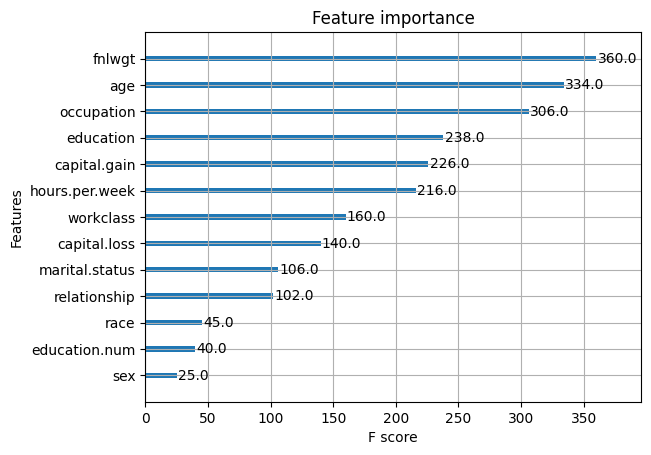

In [15]:


# plot feature importance
plot_importance(model)
pyplot.show()

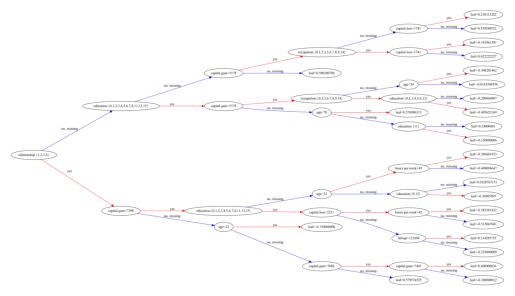

In [18]:
# plot feature importance
plot_tree(model, num_trees=0, rankdir='LR')
pyplot.show()

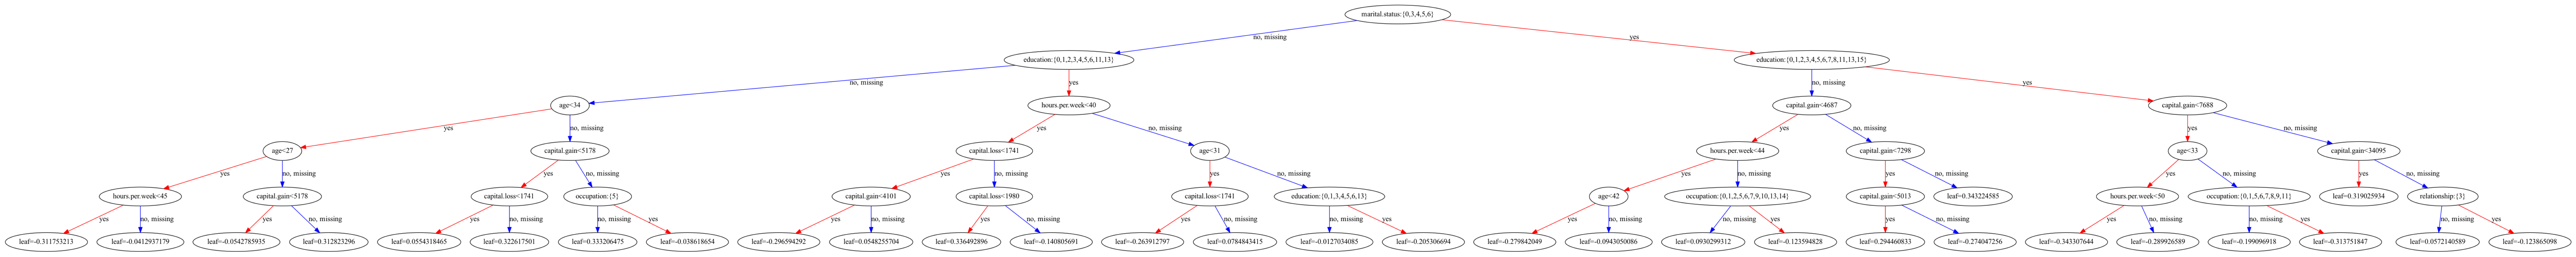

In [26]:
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(model, num_trees=4, ax=ax)

#plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

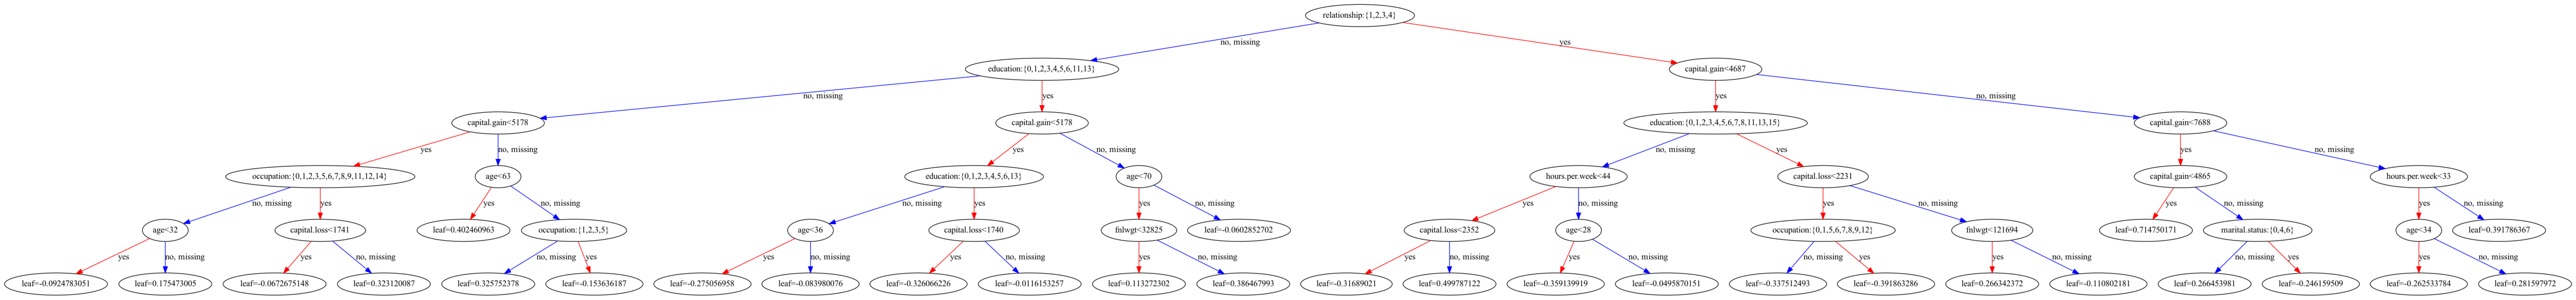

In [29]:
plot_tree(model, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
#fig.savefig('xgboost_GBtree.png')

In [16]:

cv_results = xgb.cv(
    params,
    dtrain_class,
    num_boost_round=n,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
    
mean_mae = cv_results['test-mae-mean'].min()
boost_rounds = cv_results['test-mae-mean'].argmin()
print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    


	MAE 0.1745390817175716 for 103 rounds



In [17]:
params = {'objective':'binary:logistic','eval_metric':'logloss',
          'eta':0.01,
          'subsample':0.1,
          'gamma':.2,
        'max_depth':3}
xgb_cv = xgb.cv(dtrain=dtrain_class, params=params, nfold=5, metrics = 'logloss',seed=42) 

grid = pd.DataFrame({
                    'eta':[0.01,0.05,0.1]*2,
                    'subsample':np.repeat([0.1,0.3],3),
                    'gamma':[0.01,0.05,0.1]*2,
                    'max_depth':[3,5,6]*2 
                    })

grid

,eta,subsample,gamma,max_depth
0,0.01,0.1,0.01,3
1,0.05,0.1,0.05,5
2,0.10,0.1,0.10,6
3,0.01,0.3,0.01,3
4,0.05,0.3,0.05,5
5,0.10,0.3,0.10,6


In [18]:
grid = pd.DataFrame({
                    'eta':[0.1,0.5,0.4]*2,
                    'subsample':np.repeat([0.1,0.3],3),
                    'gamma':[0.01,0.05,0.1]*2,
                    'max_depth':[3,5,6]*2 
                    })

In [19]:
def fit(x):
    params = {'objective':'binary:logistic',
              'eval_metric':'logloss',
              'min_child_weight': 1,
              'eta':x[0],
              'subsample':x[1],
              'gamma':x[2],
              'max_depth':int(x[3])
              }
    
    xgb_cv = xgb.cv(dtrain=dtrain_class, params=params, 
    nfold=5, metrics = 'logloss',seed=42)
    #best_round = xgb_cv.shape[0]-1
    #print('best_round:', best_round)
    #return best_round
    return xgb_cv[-1:].values[0]

grid[['train-logloss-mean','train-logloss-std','test-logloss-mean','test-logloss-std']] = grid.apply(fit,axis=1,result_type='expand')      

In [20]:
grid

,eta,subsample,gamma,max_depth,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.1,0.1,0.01,3,0.434845,0.001126,0.435461,0.003191
1,0.5,0.1,0.05,5,0.313872,0.002651,0.324279,0.008486
2,0.4,0.1,0.10,6,0.311782,0.002164,0.322849,0.009164
3,0.1,0.3,0.01,3,0.433227,0.000575,0.433950,0.003074
4,0.5,0.3,0.05,5,0.294845,0.003212,0.307133,0.005782
5,0.4,0.3,0.10,6,0.292456,0.001282,0.305915,0.005666


In [85]:

n=5000
params={'eta': .1, 'subsample':0.3, 'gamma':0.1, 'objective':'binary:logistic',
              'eval_metric':'logloss'}
params = {
   
    'max_depth':8,
    'min_child_weight': 1,
    'eta':.4,
    'subsample': .3,
    'colsample_bytree': 1,
    'gamma':.1,
    'reg_lambda':.4,
    "objective": "binary:logistic", "tree_method": "auto"
}
model = xgb.train(

   params=params,

   dtrain=dtrain_class,

   num_boost_round=n,

   evals=evals,

   verbose_eval=50,

   # Activate early stopping

   early_stopping_rounds=50

)


[0]	validation-logloss:0.49940	train-logloss:0.50045
[50]	validation-logloss:0.34501	train-logloss:0.21896
[100]	validation-logloss:0.39628	train-logloss:0.17225
[150]	validation-logloss:0.44693	train-logloss:0.13814
[200]	validation-logloss:0.48007	train-logloss:0.11110
[250]	validation-logloss:0.50918	train-logloss:0.09046
[300]	validation-logloss:0.53397	train-logloss:0.07542
[350]	validation-logloss:0.55213	train-logloss:0.06129
[400]	validation-logloss:0.57004	train-logloss:0.05155
[450]	validation-logloss:0.59585	train-logloss:0.04390
[500]	validation-logloss:0.61113	train-logloss:0.03747
[550]	validation-logloss:0.62906	train-logloss:0.03296
[600]	validation-logloss:0.63961	train-logloss:0.02935
[650]	validation-logloss:0.64430	train-logloss:0.02625
[700]	validation-logloss:0.65186	train-logloss:0.02340
[750]	validation-logloss:0.65508	train-logloss:0.02135
[800]	validation-logloss:0.67167	train-logloss:0.01948
[850]	validation-logloss:0.67822	train-logloss:0.01790
[900]	validat

In [26]:
y_pred = model.predict(dtest_class)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.53%


In [27]:
#!pip install hyperopt

## Hyperparameter tuning

## Bayesian optimization is optimization or finding the best parameter for a machine learning or deep learning algorithm.

## Optimization is the process of finding a minimum of cost function , that determines an overall better performance of a model on both train-set and test-set.

## train the model with various possible range of parameters until a best fit model is obtained.

## Hyperparameter tuning helps in determining the optimal tuned parameters and return the best fit model, which is the best practice to follow while building an ML or DL model.

## hyperparameter tuning method, which is Bayesian Optimization with HYPEROPT.

In [91]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## HYPEROPT is a powerful python library that search through an hyperparameter space of values and find the best possible values that yield the minimum of the loss function.

## Bayesian Optimization technique uses Hyperopt to tune the model hyperparameters. Hyperopt is a Python library which is used to tune model hyperparameters.

In [92]:
# Define the grid of hyperparameters to search

hyperparameter_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }
hyperparameter_grid={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'eta': hp.uniform('eta', 0,1),            
        'seed': 0
    }



In [93]:
hyperparameter_grid

{'max_depth': <hyperopt.pyll.base.Apply at 0x7fcd00897280>,
 'gamma': <hyperopt.pyll.base.Apply at 0x7fcd008973a0>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x7fcd00890160>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x7fcd00890a90>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7fcd008908b0>,
 'min_child_weight': <hyperopt.pyll.base.Apply at 0x7fcd00890820>,
 'n_estimators': 180,
 'eta': <hyperopt.pyll.base.Apply at 0x7fcd008904c0>,
 'seed': 0}

In [94]:
def objective(space):
    params={'n_estimators': space['n_estimators'], 
            'max_depth' : int(space['max_depth']), 
            'gamma' : space['gamma'],
            'reg_alpha' : int(space['reg_alpha']),
            'min_child_weight':int(space['min_child_weight']),
            'colsample_bytree':int(space['colsample_bytree'])}
    model=xgb.train(params=params, dtrain=dtrain_class,evals=evals,verbose_eval=50,)
    pred = model.predict(dtest_class)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [95]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = hyperparameter_grid,
                        algo = tpe.suggest,
                        max_evals = 500,
                        trials = trials)

[06:01:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44538	train-rmse:0.44559                                  
[9]	validation-rmse:0.35524	train-rmse:0.35685                                  
SCORE:                                                                          
0.8060434836015231                                                              
[06:01:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44601	train-rmse:0.44622                                  
[9]	validation-rmse:0.35742	train-rmse:0.35886                                  
SCORE:                                                                          
0.8035867829504975                                                              
[06:01:05] WARNING: /Users/runner/miniforg

[06:01:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44533	train-rmse:0.44553                                  
[9]	validation-rmse:0.35506	train-rmse:0.35669                                  
SCORE:                                                                          
0.806411988699177                                                               
[06:01:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44587	train-rmse:0.44608                                  
[9]	validation-rmse:0.35691	train-rmse:0.35839                                  
SCORE:                                                                          
0.8038324530156                                                                 
[06:01:06] WARNING: /Users/runner/miniforg

[06:01:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44654	train-rmse:0.44676                                  
[9]	validation-rmse:0.35978	train-rmse:0.36107                                  
SCORE:                                                                          
0.8000245670065103                                                              
[06:01:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44548	train-rmse:0.44569                                  
[9]	validation-rmse:0.35554	train-rmse:0.35714                                  
SCORE:                                                                          
0.8050608033411129                                                              
[06:01:08] WARNING: /Users/runner/miniforg

[06:01:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44636	train-rmse:0.44658                                  
[9]	validation-rmse:0.35910	train-rmse:0.36046                                  
SCORE:                                                                          
0.8017442574622282                                                              
[06:01:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44469	train-rmse:0.44488                                  
[9]	validation-rmse:0.35197	train-rmse:0.35390                                  
SCORE:                                                                          
0.8183269868566515                                                              
[06:01:09] WARNING: /Users/runner/miniforg

[06:01:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44498	train-rmse:0.44518                                  
[9]	validation-rmse:0.35318	train-rmse:0.35503                                  
SCORE:                                                                          
0.810711214838472                                                               
[06:01:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44462	train-rmse:0.44481                                  
[9]	validation-rmse:0.35186	train-rmse:0.35383                                  
SCORE:                                                                          
0.8185726569217541                                                              
[06:01:11] WARNING: /Users/runner/miniforg

[06:01:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44479	train-rmse:0.44499                                  
[9]	validation-rmse:0.35214	train-rmse:0.35404                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44493	train-rmse:0.44513                                  
[9]	validation-rmse:0.35279	train-rmse:0.35466                                  
SCORE:                                                                          
0.8164844613683823                                                              
[06:01:12] WARNING: /Users/runner/miniforg

[06:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44510	train-rmse:0.44530                                  
[9]	validation-rmse:0.35344	train-rmse:0.35525                                  
SCORE:                                                                          
0.8104655447733694                                                              
[06:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44547	train-rmse:0.44567                                  
[9]	validation-rmse:0.35535	train-rmse:0.35695                                  
SCORE:                                                                          
0.805552143471318                                                               
[06:01:14] WARNING: /Users/runner/miniforg

[06:01:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44472	train-rmse:0.44492                                  
[9]	validation-rmse:0.35187	train-rmse:0.35379                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44472	train-rmse:0.44492                                  
[9]	validation-rmse:0.35187	train-rmse:0.35379                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:15] WARNING: /Users/runner/miniforg

[06:01:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44460	train-rmse:0.44479                                  
[9]	validation-rmse:0.35166	train-rmse:0.35361                                  
SCORE:                                                                          
0.8183269868566515                                                              
[06:01:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44687	train-rmse:0.44710                                  
[9]	validation-rmse:0.36090	train-rmse:0.36211                                  
SCORE:                                                                          
0.7995332268763051                                                              
[06:01:17] WARNING: /Users/runner/miniforg

[06:01:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44491	train-rmse:0.44511                                  
[9]	validation-rmse:0.35273	train-rmse:0.35460                                  
SCORE:                                                                          
0.8166072964009335                                                              
[06:01:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44476	train-rmse:0.44495                                  
[9]	validation-rmse:0.35196	train-rmse:0.35387                                  
SCORE:                                                                          
0.8177128116938951                                                              
[06:01:18] WARNING: /Users/runner/miniforg

[06:01:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44627	train-rmse:0.44649                                  
[9]	validation-rmse:0.35886	train-rmse:0.36023                                  
SCORE:                                                                          
0.8019899275273308                                                              
[06:01:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44465	train-rmse:0.44485                                  
[9]	validation-rmse:0.35161	train-rmse:0.35355                                  
SCORE:                                                                          
0.8193096671170618                                                              
[06:01:20] WARNING: /Users/runner/miniforg

[06:01:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44470	train-rmse:0.44490                                  
[9]	validation-rmse:0.35181	train-rmse:0.35373                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44467	train-rmse:0.44486                                  
[9]	validation-rmse:0.35138	train-rmse:0.35333                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:22] WARNING: /Users/runner/miniforg

[06:01:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44465	train-rmse:0.44485                                  
[9]	validation-rmse:0.35131	train-rmse:0.35327                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44460	train-rmse:0.44479                                  
[9]	validation-rmse:0.35115	train-rmse:0.35313                                  
SCORE:                                                                          
0.8188183269868566                                                              
[06:01:24] WARNING: /Users/runner/miniforg

[06:01:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44533	train-rmse:0.44553                                  
[9]	validation-rmse:0.35429	train-rmse:0.35603                                  
SCORE:                                                                          
0.8091143594153053                                                              
[06:01:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44496	train-rmse:0.44516                                  
[9]	validation-rmse:0.35312	train-rmse:0.35497                                  
SCORE:                                                                          
0.810711214838472                                                               
[06:01:26] WARNING: /Users/runner/miniforg

[06:01:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44580	train-rmse:0.44601                                  
[9]	validation-rmse:0.35666	train-rmse:0.35816                                  
SCORE:                                                                          
0.8040781230807026                                                              
[06:01:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44479	train-rmse:0.44499                                  
[9]	validation-rmse:0.35214	train-rmse:0.35404                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:27] WARNING: /Users/runner/miniforg

[06:01:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44510	train-rmse:0.44530                                  
[9]	validation-rmse:0.35344	train-rmse:0.35525                                  
SCORE:                                                                          
0.8104655447733694                                                              
[06:01:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44491	train-rmse:0.44511                                  
[9]	validation-rmse:0.35279	train-rmse:0.35465                                  
SCORE:                                                                          
0.8162387913032797                                                              
[06:01:29] WARNING: /Users/runner/miniforg

[06:01:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44477	train-rmse:0.44497                                  
[9]	validation-rmse:0.35228	train-rmse:0.35418                                  
SCORE:                                                                          
0.8183269868566515                                                              
[06:01:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44463	train-rmse:0.44483                                  
[9]	validation-rmse:0.35178	train-rmse:0.35372                                  
SCORE:                                                                          
0.8183269868566515                                                              
[06:01:31] WARNING: /Users/runner/miniforg

[06:01:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44460	train-rmse:0.44479                                  
[9]	validation-rmse:0.35148	train-rmse:0.35342                                  
SCORE:                                                                          
0.8189411620194079                                                              
[06:01:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44460	train-rmse:0.44479                                  
[9]	validation-rmse:0.35166	train-rmse:0.35361                                  
SCORE:                                                                          
0.8183269868566515                                                              
[06:01:33] WARNING: /Users/runner/miniforg

[06:01:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44501	train-rmse:0.44521                                  
[9]	validation-rmse:0.35318	train-rmse:0.35500                                  
SCORE:                                                                          
0.8161159562707284                                                              
[06:01:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44514	train-rmse:0.44534                                  
[9]	validation-rmse:0.35363	train-rmse:0.35541                                  
SCORE:                                                                          
0.8102198747082668                                                              
[06:01:35] WARNING: /Users/runner/miniforg

[06:01:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44503	train-rmse:0.44523                                  
[9]	validation-rmse:0.35324	train-rmse:0.35506                                  
SCORE:                                                                          
0.8161159562707284                                                              
[06:01:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44477	train-rmse:0.44497                                  
[9]	validation-rmse:0.35207	train-rmse:0.35398                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:38] WARNING: /Users/runner/miniforg

[06:01:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44465	train-rmse:0.44485                                  
[9]	validation-rmse:0.35136	train-rmse:0.35331                                  
SCORE:                                                                          
0.8188183269868566                                                              
[06:01:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44486	train-rmse:0.44506                                  
[9]	validation-rmse:0.35260	train-rmse:0.35447                                  
SCORE:                                                                          
0.8162387913032797                                                              
[06:01:40] WARNING: /Users/runner/miniforg

[06:01:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44545	train-rmse:0.44566                                  
[9]	validation-rmse:0.35541	train-rmse:0.35702                                  
SCORE:                                                                          
0.805552143471318                                                               
[06:01:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44486	train-rmse:0.44506                                  
[9]	validation-rmse:0.35253	train-rmse:0.35442                                  
SCORE:                                                                          
0.8166072964009335                                                              
[06:01:42] WARNING: /Users/runner/miniforg

[06:01:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44462	train-rmse:0.44481                                  
[9]	validation-rmse:0.35172	train-rmse:0.35367                                  
SCORE:                                                                          
0.8183269868566515                                                              
[06:01:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44521	train-rmse:0.44541                                  
[9]	validation-rmse:0.35383	train-rmse:0.35560                                  
SCORE:                                                                          
0.8099742046431643                                                              
[06:01:45] WARNING: /Users/runner/miniforg

[06:01:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44495	train-rmse:0.44514                                  
[9]	validation-rmse:0.35285	train-rmse:0.35471                                  
SCORE:                                                                          
0.8164844613683823                                                              
[06:01:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44514	train-rmse:0.44534                                  
[9]	validation-rmse:0.35376	train-rmse:0.35556                                  
SCORE:                                                                          
0.8105883798059207                                                              
[06:01:48] WARNING: /Users/runner/miniforg

[06:01:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44472	train-rmse:0.44492                                  
[9]	validation-rmse:0.35210	train-rmse:0.35401                                  
SCORE:                                                                          
0.8183269868566515                                                              
[06:01:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44465	train-rmse:0.44485                                  
[9]	validation-rmse:0.35168	train-rmse:0.35360                                  
SCORE:                                                                          
0.8189411620194079                                                              
[06:01:50] WARNING: /Users/runner/miniforg

[06:01:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44469	train-rmse:0.44488                                  
[9]	validation-rmse:0.35174	train-rmse:0.35367                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:01:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44484	train-rmse:0.44504                                  
[9]	validation-rmse:0.35234	train-rmse:0.35422                                  
SCORE:                                                                          
0.8167301314334848                                                              
[06:01:53] WARNING: /Users/runner/miniforg

[06:01:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44472	train-rmse:0.44492                                  
[9]	validation-rmse:0.35210	train-rmse:0.35401                                  
SCORE:                                                                          
0.8183269868566515                                                              
[06:01:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44460	train-rmse:0.44479                                  
[9]	validation-rmse:0.35148	train-rmse:0.35342                                  
SCORE:                                                                          
0.8189411620194079                                                              
[06:01:55] WARNING: /Users/runner/miniforg

[06:01:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44521	train-rmse:0.44541                                  
[9]	validation-rmse:0.35383	train-rmse:0.35560                                  
SCORE:                                                                          
0.8099742046431643                                                              
[06:01:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44501	train-rmse:0.44521                                  
[9]	validation-rmse:0.35311	train-rmse:0.35495                                  
SCORE:                                                                          
0.816361626335831                                                               
[06:01:58] WARNING: /Users/runner/miniforg

[06:02:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44700	train-rmse:0.44723                                  
[9]	validation-rmse:0.36133	train-rmse:0.36250                                  
SCORE:                                                                          
0.7995332268763051                                                              
[06:02:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44507	train-rmse:0.44527                                  
[9]	validation-rmse:0.35351	train-rmse:0.35532                                  
SCORE:                                                                          
0.810711214838472                                                               
[06:02:01] WARNING: /Users/runner/miniforg

[06:02:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44505	train-rmse:0.44525                                  
[9]	validation-rmse:0.35324	train-rmse:0.35507                                  
SCORE:                                                                          
0.816361626335831                                                               
[06:02:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:0.44467	train-rmse:0.44486                                  
[9]	validation-rmse:0.35168	train-rmse:0.35361                                  
SCORE:                                                                          
0.8186954919543054                                                              
[06:02:03] WARNING: /Users/runner/miniforg

In [96]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7885425400431152, 'eta': 0.04775173031805857, 'gamma': 2.474512882968948, 'max_depth': 9.0, 'min_child_weight': 3.0, 'reg_alpha': 43.0, 'reg_lambda': 0.7563728786218638}


In [97]:
def fit(x):
    n=5000
    params={'eta': .1, 'subsample':0.3, 'gamma':0.1, 'objective':'binary:logistic',
                  'eval_metric':'logloss'}
    params = {

        'max_depth':9,
        'min_child_weight': 3,
        'eta':.04,
        'subsample': .3,
        'colsample_bytree': .78,
        'gamma':2.47,
        'reg_alpha': 43.0, 
        'reg_lambda': 0.75,
        "objective": "binary:logistic", "tree_method": "hist"
    }

    model = xgb.cv(

       params=params,

       dtrain=dtrain_class,

       num_boost_round=n,

       nfold=10,

       verbose_eval=50,

       # Activate early stopping

       early_stopping_rounds=100

    )
    return model[-1:].values[0]

In [100]:
y_pred = model.predict(dtest_class)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.53%


In [99]:
grid[['train-logloss-mean','train-logloss-std','test-logloss-mean','test-logloss-std']] = \
grid.apply(fit,axis=1,result_type='expand')

[0]	train-logloss:0.67382+0.00011	test-logloss:0.67385+0.00024
[50]	train-logloss:0.37686+0.00073	test-logloss:0.37812+0.00428
[100]	train-logloss:0.33797+0.00070	test-logloss:0.33989+0.00540
[150]	train-logloss:0.32706+0.00095	test-logloss:0.32920+0.00569
[200]	train-logloss:0.32394+0.00080	test-logloss:0.32617+0.00604
[250]	train-logloss:0.32277+0.00085	test-logloss:0.32505+0.00599
[300]	train-logloss:0.32210+0.00076	test-logloss:0.32438+0.00612
[350]	train-logloss:0.32155+0.00077	test-logloss:0.32389+0.00613
[400]	train-logloss:0.32111+0.00077	test-logloss:0.32347+0.00619
[450]	train-logloss:0.32070+0.00078	test-logloss:0.32313+0.00620
[500]	train-logloss:0.32037+0.00086	test-logloss:0.32284+0.00620
[550]	train-logloss:0.32014+0.00086	test-logloss:0.32261+0.00617
[600]	train-logloss:0.31991+0.00087	test-logloss:0.32237+0.00618
[650]	train-logloss:0.31970+0.00089	test-logloss:0.32214+0.00612
[700]	train-logloss:0.31938+0.00083	test-logloss:0.32186+0.00623
[750]	train-logloss:0.31914+

[1200]	train-logloss:0.31802+0.00097	test-logloss:0.32057+0.00618
[1250]	train-logloss:0.31793+0.00099	test-logloss:0.32051+0.00615
[1300]	train-logloss:0.31780+0.00098	test-logloss:0.32037+0.00615
[1350]	train-logloss:0.31773+0.00096	test-logloss:0.32029+0.00619
[1400]	train-logloss:0.31768+0.00096	test-logloss:0.32023+0.00618
[1450]	train-logloss:0.31757+0.00097	test-logloss:0.32013+0.00620
[1500]	train-logloss:0.31743+0.00102	test-logloss:0.31999+0.00619
[1550]	train-logloss:0.31735+0.00105	test-logloss:0.31992+0.00616
[1600]	train-logloss:0.31729+0.00107	test-logloss:0.31986+0.00615
[1650]	train-logloss:0.31723+0.00104	test-logloss:0.31979+0.00622
[1700]	train-logloss:0.31713+0.00100	test-logloss:0.31970+0.00627
[1750]	train-logloss:0.31710+0.00100	test-logloss:0.31966+0.00628
[1800]	train-logloss:0.31699+0.00096	test-logloss:0.31954+0.00636
[1850]	train-logloss:0.31691+0.00098	test-logloss:0.31948+0.00633
[1900]	train-logloss:0.31684+0.00098	test-logloss:0.31941+0.00631
[1950]	tra

[2400]	train-logloss:0.31632+0.00099	test-logloss:0.31893+0.00628
[2450]	train-logloss:0.31628+0.00099	test-logloss:0.31889+0.00627
[2500]	train-logloss:0.31623+0.00097	test-logloss:0.31884+0.00631
[2550]	train-logloss:0.31618+0.00096	test-logloss:0.31880+0.00631
[2600]	train-logloss:0.31613+0.00096	test-logloss:0.31874+0.00633
[2650]	train-logloss:0.31609+0.00097	test-logloss:0.31870+0.00635
[2700]	train-logloss:0.31602+0.00094	test-logloss:0.31865+0.00639
[2750]	train-logloss:0.31596+0.00094	test-logloss:0.31859+0.00638
[2800]	train-logloss:0.31595+0.00094	test-logloss:0.31859+0.00638
[2850]	train-logloss:0.31590+0.00095	test-logloss:0.31854+0.00637
[2900]	train-logloss:0.31587+0.00094	test-logloss:0.31851+0.00637
[2950]	train-logloss:0.31582+0.00095	test-logloss:0.31846+0.00636
[3000]	train-logloss:0.31573+0.00099	test-logloss:0.31837+0.00631
[3050]	train-logloss:0.31568+0.00097	test-logloss:0.31832+0.00633
[3100]	train-logloss:0.31565+0.00096	test-logloss:0.31827+0.00634
[3150]	tra

[3600]	train-logloss:0.31533+0.00095	test-logloss:0.31796+0.00637
[3650]	train-logloss:0.31528+0.00096	test-logloss:0.31792+0.00637
[3700]	train-logloss:0.31525+0.00096	test-logloss:0.31789+0.00638
[3750]	train-logloss:0.31520+0.00094	test-logloss:0.31785+0.00641
[3800]	train-logloss:0.31516+0.00092	test-logloss:0.31781+0.00641
[3850]	train-logloss:0.31512+0.00090	test-logloss:0.31777+0.00643
[3900]	train-logloss:0.31510+0.00088	test-logloss:0.31776+0.00645
[3950]	train-logloss:0.31508+0.00088	test-logloss:0.31774+0.00645
[4000]	train-logloss:0.31506+0.00088	test-logloss:0.31772+0.00645
[4050]	train-logloss:0.31505+0.00087	test-logloss:0.31770+0.00646
[4100]	train-logloss:0.31499+0.00085	test-logloss:0.31764+0.00650
[4150]	train-logloss:0.31496+0.00084	test-logloss:0.31762+0.00649
[4200]	train-logloss:0.31495+0.00085	test-logloss:0.31761+0.00648
[4250]	train-logloss:0.31490+0.00084	test-logloss:0.31756+0.00650
[4300]	train-logloss:0.31488+0.00084	test-logloss:0.31754+0.00653
[4350]	tra

[4800]	train-logloss:0.31458+0.00085	test-logloss:0.31727+0.00647
[4850]	train-logloss:0.31455+0.00086	test-logloss:0.31725+0.00647
[4900]	train-logloss:0.31452+0.00086	test-logloss:0.31722+0.00646
[4950]	train-logloss:0.31448+0.00084	test-logloss:0.31719+0.00649
[4999]	train-logloss:0.31444+0.00085	test-logloss:0.31714+0.00650
[0]	train-logloss:0.67382+0.00011	test-logloss:0.67385+0.00024
[50]	train-logloss:0.37686+0.00073	test-logloss:0.37812+0.00428
[100]	train-logloss:0.33797+0.00070	test-logloss:0.33989+0.00540
[150]	train-logloss:0.32706+0.00095	test-logloss:0.32920+0.00569
[200]	train-logloss:0.32394+0.00080	test-logloss:0.32617+0.00604
[250]	train-logloss:0.32277+0.00085	test-logloss:0.32505+0.00599
[300]	train-logloss:0.32210+0.00076	test-logloss:0.32438+0.00612
[350]	train-logloss:0.32155+0.00077	test-logloss:0.32389+0.00613
[400]	train-logloss:0.32111+0.00077	test-logloss:0.32347+0.00619
[450]	train-logloss:0.32070+0.00078	test-logloss:0.32313+0.00620
[500]	train-logloss:0.3

In [101]:
grid

,eta,subsample,gamma,max_depth,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.1,0.1,0.01,3,0.314438,0.000845,0.317138,0.006496
1,0.5,0.1,0.05,5,0.314438,0.000845,0.317138,0.006496
2,0.4,0.1,0.10,6,0.314438,0.000845,0.317138,0.006496
3,0.1,0.3,0.01,3,0.314438,0.000845,0.317138,0.006496
4,0.5,0.3,0.05,5,0.314438,0.000845,0.317138,0.006496
5,0.4,0.3,0.10,6,0.314438,0.000845,0.317138,0.006496


In [81]:
  params = {

        'max_depth':7,
        'min_child_weight': 9,
        'eta':.4,
        'subsample': .3,
        'colsample_bytree': .64,
        'gamma':.1,
        'reg_alpha': 40.0, 
        'reg_lambda': 0.04,
        "objective": "binary:logistic", "tree_method": "auto"
    }
model=xgb.train(

       params=params,

       dtrain=dtrain_class,

       num_boost_round=n,

        evals=evals,
       verbose_eval=50,

       # Activate early stopping

       early_stopping_rounds=100

    )

[0]	validation-logloss:0.53129	train-logloss:0.53217
[50]	validation-logloss:0.30585	train-logloss:0.30967
[100]	validation-logloss:0.30236	train-logloss:0.30602
[150]	validation-logloss:0.30050	train-logloss:0.30426
[200]	validation-logloss:0.29883	train-logloss:0.30236
[250]	validation-logloss:0.29790	train-logloss:0.30116
[300]	validation-logloss:0.29642	train-logloss:0.29955
[350]	validation-logloss:0.29531	train-logloss:0.29865
[400]	validation-logloss:0.29508	train-logloss:0.29804
[450]	validation-logloss:0.29481	train-logloss:0.29760
[500]	validation-logloss:0.29459	train-logloss:0.29691
[550]	validation-logloss:0.29389	train-logloss:0.29632
[600]	validation-logloss:0.29331	train-logloss:0.29562
[650]	validation-logloss:0.29289	train-logloss:0.29499
[700]	validation-logloss:0.29222	train-logloss:0.29440
[750]	validation-logloss:0.29211	train-logloss:0.29403
[800]	validation-logloss:0.29183	train-logloss:0.29363
[850]	validation-logloss:0.29160	train-logloss:0.29315
[900]	validat

In [82]:
y_pred = model.predict(dtest_class)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.15%
